# Force inference from stochastic trajectories

In [3]:
import sys
data_path = './'
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    data_path = '/content/drive/My Drive/biophysics_summer_school_2025/data_tutorial_3/'
    sys.path.append('/content/drive/My Drive/biophysics_summer_school_2025')

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils import get_basis, greedy_basis_search, evaluate_basis, get_latex_model, get_model_from_labels, add_superfluous_functions

Mounted at /content/drive


## 1. Simulating the stochastic Lorenz system

We consider a stochastic trajectory $\{\mathbf{x}_t\}$ sampled at constant time intervals $\Delta t$. The dynamics are governed by the SDE:

$$
\frac{d\mathbf{x}_t}{dt} = \mathbf{F}(\mathbf{x}_t) + \sqrt{2\mathbf{D}} \, \boldsymbol{\xi}_t,
$$

where $\mathbf{F}(\mathbf{x})$ is the unknown force field, $\mathbf{D}$ is the (constant) diffusion matrix, and $\boldsymbol{\xi}_t$ is a Gaussian white noise. In this specific tutorial we consider the case $\mathbf{x} = (x, y, z)$ with $\mathbf{F}$ is the deterministic Lorenz drift. The deterministic Lorenz dynamics are:

\begin{aligned}
\frac{dx}{dt} &= \sigma (y - x), \\
\frac{dy}{dt} &= x (\rho - z) - y, \\
\frac{dz}{dt} &= xy - \beta z.
\end{aligned}

We can simulate using the Euler–Maruyama method, which approximates stochastic differential equations over small time steps:

$$
\mathbf{x}_{t+\Delta t} = \mathbf{x}_t + \mathbf{F}(\mathbf{x}_t) \, \Delta t + \sqrt{2\mathbf{D} \, \Delta t} \cdot \boldsymbol{\eta}_t,
$$

where $\boldsymbol{\eta}_t \sim \mathcal{N}(0, I)$. **<font color='red'>Simulate this system with $\sigma = 10$, $\rho = 28$, $\beta = \frac{7}{3}$, $D = 10$, $\Delta t = 10^{-4}$, $T = 150$.</font>**

In [4]:
def lorenz_force(X, args):
    """
    Compute the deterministic Lorenz drift vector field for input positions.

    Parameters:
        X : ndarray of shape (time, 3)
            Points at which to evaluate the force.
        args : tuple of floats (sigma, rho, beta)
            Lorenz system parameters.

    Returns:
        dXdt : ndarray of shape (time, 3)
            Time derivative at each position.
    """

    dXdt = np.empty_like(X)
    sigma, rho, beta = args

    dXdt[:, 0] = sigma * (X[:, 1] - X[:, 0])
    dXdt[:, 1] = X[:, 0] * (rho - X[:, 2]) - X[:, 1]
    dXdt[:, 2] = X[:, 0]*X[:, 1] - beta * X[:, 2]

    return dXdt

def simulate(X0, force_args, force_function=lorenz_force,
             dt=0.0002, T=20.0, D=100.0, num=10):

    """
    Simulate a stochastic trajectory using Euler-Maruyama integration.

    Parameters:
        X0 : ndarray of shape (3,)
            Initial condition for the Lorenz system.
        force_args : tuple
            Parameters for the deterministic force.
        force_function : callable
            Function computing the drift force.
        dt : float
            Time step.
        T : float
            Total duration to record.
        D : float
            Scalar noise strength.
        num : int
            Store one frame every 'num' steps.

    Returns:
        trajectory : ndarray of shape (time, 3), stochastic trajectory:
    """
    X = X0.copy()

    n_steps = int(T / dt)
    trajectory = []

    for i in tqdm(range(0, n_steps)):
        drift = force_function(X[None, :], force_args)[0,:]
        noise = np.sqrt(2 * D * dt) * np.random.randn(3)
        X += drift * dt + noise
        if (i % num == 0):
            trajectory.append(X.copy())

    trajectory = np.array(trajectory)
    return trajectory


In [5]:
dt=0.0001
T=80.0
D=10
num=20
np.random.seed(2)
x0 = np.array([0.5, 0.5, 23])
force_args = (10.0, 28.0, 7.0/3.0)
X = simulate(x0, force_args, dt=dt, T=T, D=D, num = num)

100%|██████████| 800000/800000 [00:16<00:00, 49089.55it/s]


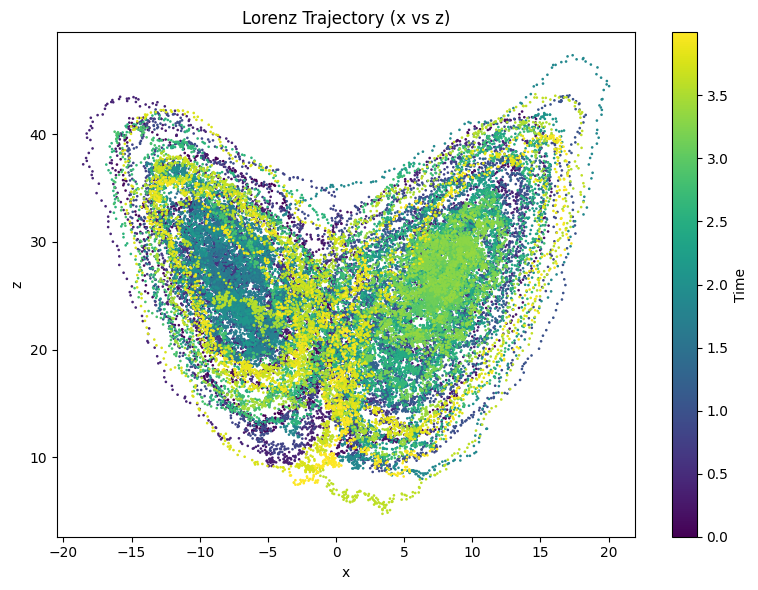

In [6]:
x = X[:, 0]
y = X[:, 1]
z = X[:, 2]
t = np.arange(len(x)) * dt

plt.figure(figsize=(8, 6))
scatter = plt.scatter(x, z, c=t, cmap='viridis', s=0.8)
plt.xlabel("x")
plt.ylabel("z")
plt.title("Lorenz Trajectory (x vs z)")
cbar = plt.colorbar(scatter, label='Time')
plt.tight_layout()
plt.show()


## 2. Estimating the diffusion coefficient

In order to infer the force field, we first need to the diffusion matrix $\hat{\mathbf{D}} \simeq \mathbf{D}$. To do that, we can simply build a naive estimator using the Euler-Maryuma time stepping. When $\Delta t \rightarrow 0$ we have that:

$$
\hat{\mathbf{D}} \simeq \frac{1}{2\Delta t} \langle \Delta \mathbf{x}_t \Delta \mathbf{x}_t^T \rangle
$$

**<font color='red'>Write the function to compute the mean diffusion and compare the diffusion matrix inferred to the true one, which is diagonal with $D = 10$.</font>**

In [7]:
def compute_mean_diffusion(X, T):
    """
    Estimate the diffusion matrix from a trajectory using the empirical second moment.

    Parameters:
        X : ndarray of shape (Nt, d)
            Trajectory data.
        T : float
            Total time of the trajectory.

    Returns:
        Dhat : ndarray of shape (d, d)
            Estimated diffusion matrix.
    """

    dt = T/X.shape[0]

    dX = (X[1:] - X[:-1])
    Dhat = dX.T@dX / (2 * T)
    return Dhat


In [8]:
compute_mean_diffusion(X, T)

array([[11.28526464,  1.43744344,  0.18137786],
       [ 1.43744344, 12.62973599, -0.03251832],
       [ 0.18137786, -0.03251832, 13.94956311]])

## 3. Regressing the force field

We now implement the regression of the force field. To infer $\mathbf{F}$ from data, we introduce a test force field $\hat{\mathbf{F}}(\mathbf{x})$, assumed to lie in a linear span of vector basis functions $\{\mathbf{b}_i(\mathbf{x})\}$:

$$
\hat{\mathbf{F}}(\mathbf{x}) = \sum_{i=1}^{n_B} \hat{F}_i \, \mathbf{b}_i(\mathbf{x}),
$$

where the coefficients $\hat{F}_i$ are to be inferred from the data. A notation of importance is the average over time, which simply implements Riemann integral, with $T$ is the total duration of the trajectory and $\Delta t$ the time step.

$$
\langle \cdot \rangle = \frac{1}{T} \sum_t \cdot \Delta t
$$
The log-likelihood of the trajectory under the test force field is approximated in discrete time by:

$$
\mathcal{L}(\hat{\mathbf{F}}) = -\frac{T}{4} \langle  \left( \frac{\Delta \mathbf{x}_t}{\Delta t} - \hat{\mathbf{F}}(\mathbf{x}_t) \right)^T \hat{\mathbf{D}}^{-1} \left( \frac{\Delta \mathbf{x}_t}{\Delta t} - \hat{\mathbf{F}}(\mathbf{x}_t) \right) \rangle.
$$

where $\Delta \mathbf{x}_t = \mathbf{x}_{t+\Delta t} - \mathbf{x}_t$ is the discrete velocity. Minimizing $\mathcal{L}$ with respect to the coefficients $\hat{F}_i$ gives the linear system:

$$
\mathbf{G} \hat{\mathbf{F}} = \hat{\mathbf{b}}.
$$

where

$$
G_{ij} = \langle \mathbf{b}_i(\mathbf{x}_t)^T \mathbf{D}^{-1} \mathbf{b}_j(\mathbf{x}_t) \rangle, \qquad
\hat{b}_j = \langle \left( \frac{\Delta \mathbf{x}_t}{\Delta t} \right)^T \mathbf{D}^{-1} \mathbf{b}_j(\mathbf{x}_t) \rangle,
$$

If we expand the average over time the formulas read:

$$
G_{ij} = \frac{\Delta t}{T} \sum_{a=1}^d \sum_{b=1}^d \sum_t \, b_{ia}(\mathbf{x}_t) \, (\hat{D}^{-1})_{ab} \, b_{jb}(\mathbf{x}_t) = \frac{\Delta t}{T}  \, b_{ia}(\mathbf{x}_t) \, (\hat{D}^{-1})_{ab} \, b_{jb}(\mathbf{x}_t),
,
$$

$$
\hat{b}_i = \frac{\Delta t}{T} \sum_{a=1}^d \sum_{b=1}^d \sum_t \, \frac{\Delta x_{ta}}{\Delta t} \, (\hat{D}^{-1})_{ab} \, b_{ib}(\mathbf{x}_t) = \frac{\Delta t}{T}  \, \frac{\Delta x_{ta}}{\Delta t} \, (\hat{D}^{-1})_{ab} \, b_{ib}(\mathbf{x}_t).
$$

where for the second equality we have used the **Einstein summation** notation, for which repeated indices are summed over. Given two 2D numpy arrays A, and B of compatible dimensions `np.einsum('ik,kj->ij', A, B)` will implement the matrix product $(AB)_{ij} = \sum_{k} A_{ik}B_{kj}$. You can use more than three matrices and implement more complicated summations: `np.einsum('ik,tk,tij->j', A, B, C)` will implement the product $A_{ik} B_{tk} C_{tij}$ where we use the repeated einstein summation convention. The function einsum has an option `optimize=True` which accelerates it.

To help you, we provide a function called `get_basis` which returns a basis of functions of arbitrary polynomial degrees for arbitrary space dimensions. We also provide a function `evaluate_basis` which takes the functions basis, the data $X$ of dimension $(Nt, d)$ where the first axis is time, and the second is space, and evaluates $\mathbf{b}(\mathbf{x}_t)$ for all times and all basis. This returns an array $B$ of dimension $Nt, nB, d$ where the first dimension is time, the second is the basis function index, and the third the spatial dimension. A given entry $B_{tia} = b_{ia}(\mathbf{x}_t)$.

```python
# Returns a polynomial basis of degree 2 for variables of dimension d = 3
basis = get_basis(field_dim=3, degree=2)

# Evalute the basis functions on the trajectory X of dimensions (Nt, d)
B = evaluate_basis(X, basis)
```

**<font color='red'>Write the function `infer_force_coefficients` which computes $\mathbf{G}$, $\hat{\mathbf{b}}$ and solves the linear system</font>**.Once the optimal coefficients $\hat{F}_i$ have been inferred, the force field at any point $\mathbf{x}$ will be reconstructed as a linear combination of the active basis functions. This is done with the function `reconstruct_force_field` which we provide. **<font color='red'>Compare the true and the inferred force field with a scatter plot.</font>**

In [9]:
def infer_force_coefficients(X, T, basis_functions):
    """
    Estimate the force coefficients using Einstein summation instead of loops.

    Parameters:
        X : ndarray of shape (Nt, d)
            Trajectory data.
        T : float
            Total simulation time.
        basis_functions : list of callables
            Basis functions mapping from position to vector field.

    Returns:
        Fhat : ndarray of shape (nB,)
            Estimated force coefficients.
    """
    dt = T/X.shape[0]
    dXdt = (X[1:] - X[:-1]) / dt
    B = evaluate_basis(X[:-1], basis_functions) #(N_t, n_B, 3)

    D_hat = compute_mean_diffusion(X, T)
    D_inv = np.linalg.inv(D_hat)

    # Gram matrix
    G = np.einsum('ab,tia,tjb->ij', D_inv, B, B, optimize=True) * dt / T
    # RHS vector
    b = np.einsum('ab,ta,tjb->j', D_inv, dXdt, B, optimize=True) * dt / T

    Fhat = np.linalg.solve(G, b)
    return Fhat

def reconstruct_force_field(X, coeffs, basis_functions):
    """
    Reconstruct the inferred force field at each point in the trajectory.

    Parameters:
        X : ndarray of shape (Nt, d)
            Trajectory positions.
        coeffs : ndarray of shape (nB,)
            Coefficients for the basis functions.
        basis_functions : dict of callables
            Dictionary of basis functions mapping to vector fields.

    Returns:
        F : ndarray of shape (Nt, d)
            Reconstructed force field at each time step.
    """
    Y = np.moveaxis(X, 0, 1)
    F = np.zeros_like(Y)
    for c, f in zip(coeffs, basis_functions.values()):
        F += c * f(Y)
    F = np.moveaxis(F, 1, 0)
    return F

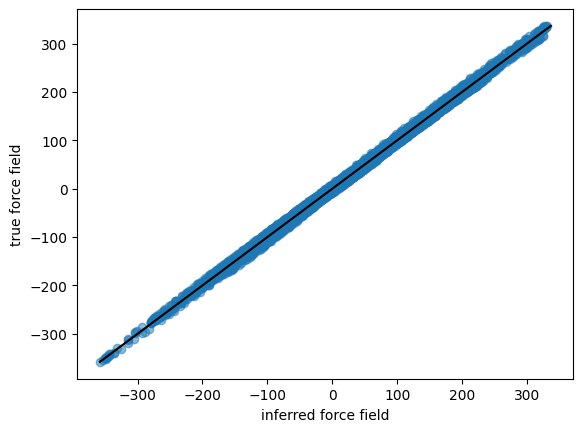

In [13]:
basis = get_basis(field_dim=3, degree=2)
coeffs = infer_force_coefficients(X, T, basis)

F_inf = reconstruct_force_field(X, coeffs, basis)
F_true = lorenz_force(X, force_args)

plt.figure()
plt.scatter(F_inf.flatten(), F_true.flatten(), alpha = 0.5)
x = np.linspace(F_true.min(), F_true.max())
plt.plot(x, x, 'k-')
plt.xlabel('inferred force field')
plt.ylabel('true force field')
plt.show()

## 4. Maximizing the log-likelihood

We denote $B$ the basis of functions used to infer the force, also denoted $\hat{\mathbf{F}}^B(\mathbf{x})$. We can evaluate the **log-likelihood** of the trajectory under this force model:

$$
\mathcal{L}(\hat{\mathbf{F}}) = -\frac{T}{4} \langle  \left( \frac{\Delta \mathbf{x}_t}{\Delta t} - \hat{\mathbf{F}}(\mathbf{x}_t) \right)^T \hat{\mathbf{D}}^{-1} \left( \frac{\Delta \mathbf{x}_t}{\Delta t} - \hat{\mathbf{F}}(\mathbf{x}_t) \right) \rangle.
$$

One we have fit the force given the basis $B$, it is tempting to use a second time the value of the log-likelihood of the $\mathcal{L}$ data to find the best basis $B$. However, this will favor models with more functions, which will overfit the data and lead to larger error on the force reconstruction.

This can be seen using the equation for $\mathcal{L}$ and $\Delta \mathbf{x}_t/\Delta t = \mathbf{F}(\mathbf{x}_t) + \sqrt{2\mathbf{D}} \boldsymbol\eta_t/\sqrt{\Delta t}$. We get, if we also assume that the estimated diffusion matches well the true diffusion, ie $\mathbf{D} \simeq \hat{\mathbf{D}}$

\begin{align}
\mathcal{L}(\hat{\mathbf{F}}^B) \simeq - \frac{T}{4} \langle (\mathbf{F} - \hat{\mathbf{F}}^B)) \mathbf{D}^{-1} (\mathbf{F} - \hat{\mathbf{F}}^B)) \rangle + n_B - \frac{dT}{2 \Delta t} \\
=- T \mathcal{E}(\mathbf{F}^{B}) + n_B - \frac{d T}{2 \Delta t}
\end{align}

where $n_B$ is the number of functions in the basis $B$, $d$ the dimension (here 3), and we recognize $\mathcal{E}(\mathbf{F}^{B}) = \langle (\mathbf{F} - \hat{\mathbf{F}}^B)) \mathbf{D}^{-1} (\mathbf{F} - \hat{\mathbf{F}}^B)) \rangle$ the reconstruction error between the **true** force field and the **inferred** one. We understand that by searching for a base that maximizes the log-likelihood (ie maximizing $\mathcal{L}$), we will find a base $B^*$ that in fact solves:

$$
B^* = \arg\max_{B} \left( -T \mathcal{E}(\mathbf{F}^{B}) + n_B\right)
$$

Therefore, adding more function in the basis will be favored thanks to the term $n_B$, which can grow arbitrarily big. **This is overfitting**. We provide the `add_superfluous_functions` which will start from the true model and add functions which are not in the true model and returns the log-likelihood and the error for each of these new basis. **<font color='red'>Show that adding functions to the true model increases the log-likelihood, but also increases the error: this comes from the term proportional to $n_B$ in the equation above.</font>**

In [ ]:
def compute_log_likelihood(X, T, coeffs, basis_functions):
    """
    Compute the log-likelihood of the trajectory under the inferred force.

    Parameters:
        X : ndarray of shape (Nt, d)
            Trajectory data.
        T : float
            Total simulation time.
        coeffs : ndarray of shape (nB,)
            Coefficients for the basis functions.
        basis_functions : dict
            Dictionary of basis functions.

    Returns:
        L : float
            Log-likelihood of the trajectory.
    """
    dt = T/X.shape[0]

    dXdt = (X[1:] - X[:-1]) / dt

    F = reconstruct_force_field(X[:-1], coeffs, basis_functions)
    residual = dXdt - F

    D_hat = compute_mean_diffusion(X, T)
    D_inv = np.linalg.inv(D_hat)

    L = -0.25*np.einsum('ab,ta,tb', D_inv, residual, residual, optimize=True)*dt

    return L

def compute_reconstruction_error(X, T, coeffs, basis):
    """
    Compute the error between the true and inferred force fields.

    Parameters:
        X : ndarray of shape (Nt, d)
            Trajectory positions.
        T : float
            Total simulation time.
        coeffs : ndarray of shape (nB,)
            Coefficients for the inferred force.
        basis : dict
            Dictionary of basis functions.

    Returns:
        error : float
            Scalar reconstruction error.
    """
    dt = T/X.shape[0]

    F_true = lorenz_force(X[:-1], force_args)
    F_inf = reconstruct_force_field(X[:-1], coeffs, basis)

    D_hat = compute_mean_diffusion(X, T)
    D_inv = np.linalg.inv(D_hat)

    DeltaF = F_true - F_inf
    error = 0.25*np.einsum('ab,ta,tb', D_inv, DeltaF, DeltaF, optimize=True)*dt/T

    return error


def add_superfluous_functions(X, T, basis, true_model):
    """
    Add basis functions to the true model one by one, and track score changes.

    Parameters:
        X : ndarray of shape (Nt, d)
            Trajectory data.
        T : float
            Total simulation time.
        basis : dict
            Dictionary of all available basis functions.
        true_model : dict
            Dictionary of ground-truth basis functions.

    Returns:
        log_liks : ndarray
            Log-likelihood after each added function.
        errors : ndarray
            Reconstruction after each added function.
    """
    dt = T/X.shape[0]
    all_labels = list(basis.keys())
    true_labels = list(true_model.keys())

    remaining_labels = list(set(all_labels) - set(true_labels))
    np.random.shuffle(remaining_labels)

    log_liks = []
    errors = []
    size_basis = []

    current_labels = true_labels

    for _label in remaining_labels:
        current_labels = current_labels + [_label]
        current_model = {label: basis[label] for label in current_labels}

        coeffs = infer_force_coefficients(X, T, current_model)
        log_lik = compute_log_likelihood(X, T, coeffs, current_model)
        error = compute_reconstruction_error(X, T, coeffs, current_model)

        log_liks.append(log_lik)
        errors.append(error)
        size_basis.append(len(current_model))

    log_liks = np.array(log_liks)
    errors = np.array(errors)
    return log_liks, errors

In [ ]:
true_labels = [
    "$e_{0} u_{1}^{1}$",
    "$e_{0} u_{0}^{1}$",
    "$e_{1} u_{0}^{1}$",
    "$e_{1} u_{0}^{1} u_{2}^{1}$",
    "$e_{1} u_{1}^{1}$",
    "$e_{2} u_{2}^{1}$",
    "$e_{2} u_{0}^{1} u_{1}^{1}$",
]
true_model = get_model_from_labels(true_labels, field_dim=3)
log_liks, errors = add_superfluous_functions(X, T, basis, true_model)

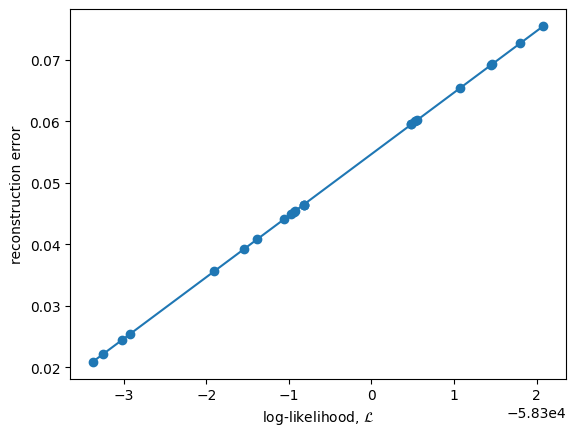

In [ ]:
plt.figure()
plt.plot(log_liks, errors, 'o-')
plt.ylabel('reconstruction error')
plt.xlabel('log-likelihood, $\mathcal{L}$')
plt.show()

## 5. How to avoid overfitting ?

To avoid overfitting and select the best subset of basis functions, we would rather want to minimize directly the reconstruction error. Thanks to the relationship between the log-likelihood and the error, we see that if define a new penalized log-likelihood:

$$
\mathcal{L}_{\mathrm{AIC}} (\hat{\mathbf{F}}^B) = \mathcal{L} (\hat{\mathbf{F}}^B) - n_B
$$

we are ensured that:

$$
\mathcal{L}_{\mathrm{AIC}} \simeq -T \mathcal{E}(\mathbf{F}^{B})
$$

This is what we need, since now searching for a base which maximizes $\mathcal{L}^{\mathrm{AIC}}$ is the same as minimizing the reconstruction error. This is called the Aikaike Information Criterion.

**However, we have hidden something, the relationship between the log-likelihood and the error only holds on average** over an ensemble of trajectories. For a single trajectory, this relation always has a non-zero probability not to hold, even for infinitely long ($T \rightarrow \infty$) and infinitely well sampled ($\Delta t \rightarrow 0$) trajectories. This means that we could include an incorrect function which increases $\mathcal{L}^{\mathrm{AIC}}$ while also increasing $\mathcal{E}(\mathbf{F}^{B})$. For this reason, the authors of SFI recently proposed a modified criterion, called PASTIS, for which this phenomenon doesn't occur. This criterion reads:

$$
\mathcal{L}_{\text{PASTIS}} = \mathcal{L} (\hat{\mathbf{F}}^B) - n_B \log\left(\frac{n_0}{p}\right),
$$

where $p$ is a parameter which sets the probability of having $\Delta \mathcal{L}_{\mathrm{PASTIS}}$ and $\Delta \mathcal{E}$ having the same sign, and $n_0$ is the total number of functions in the basis.

Using the function `add_superfluous_functions`, you can compute the change in $\Delta \mathcal{L}_{\mathrm{AIC}}$, $\Delta \mathcal{L}_{\mathrm{PASTIS}}$ and $-T \Delta \mathcal{E}$ occuring everytime you add an additional function to the model. We provide a snippet of code to compute the log-likelihood and the error when adding superfluous functions for `ntrials`repetitions. **<font color='red'>From this, plot histograms of $\Delta \mathcal{L}_{\mathrm{AIC}}$, $-T\Delta \mathcal{E}$ and $\Delta \mathcal{L}_{\mathrm{PASTIS}}$.</font>**

You should notice that $-T\Delta \mathcal{E}$ is always negative since adding a function that is not in the true model can only increase the reconstruction error. The interesting observation is then that $\Delta \mathcal{L}_{\mathrm{AIC}}$ can be positive, even though on average it is negative. This means that adding an additional superfluous function is unfavored on average, but can be favored if we are unlucky. The other observation is that the effect of $\Delta \mathcal{L}_{\mathrm{PASTIS}}$ is to shift the histogram towards more negative values, such that the probability of $\Delta \mathcal{L}_{\mathrm{PASTIS}}$ being positive is negligible, and maximizing $\Delta \mathcal{L}_{\mathrm{PASTIS}}$ is a better approach.

Finally, we can go even beyond and predict that $\Delta \mathcal{L}$ is distributed like $Z/2$ where $Z \sim \chi_1^2$ is a chi-square variable. **<font color='red'>Plot this prediction on top of the histograms (there is a shift to account for to overlay it with $\Delta \mathcal{L}_{\mathrm{AIC}}$ and $\Delta \mathcal{L}_{\mathrm{PASTIS}}$).</font>**

In [ ]:
log_liks = []
errors = []
ntrials = 5
dt=0.0001
T=80.0
D=10
num=20
np.random.seed(2)
x0 = np.array([0.5, 0.5, 23])
force_args = (10.0, 28.0, 7.0/3.0)

for _ in range(ntrials):
    X = simulate(x0, force_args, dt=dt, T=T, D=D, num = num)
    _log_liks, _errors = add_superfluous_functions(X, T, basis, true_model)
    log_liks.append(_log_liks)
    errors.append(_errors)

log_liks = np.array(log_liks)
errors = np.array(errors)

100%|██████████| 1000000/1000000 [00:26<00:00, 37471.15it/s]


Text(0, 0.5, 'frequency')

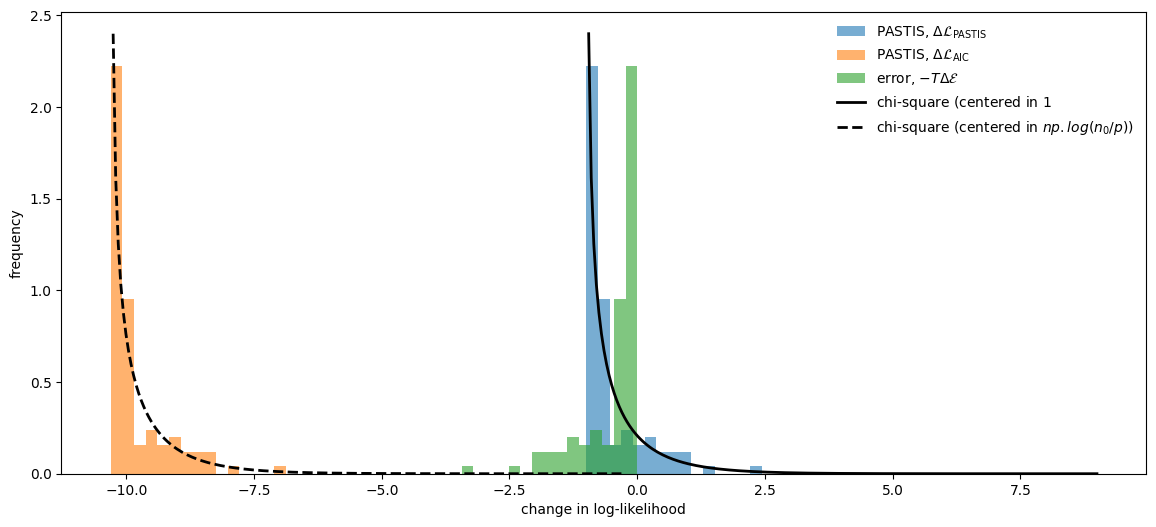

In [ ]:
size_bases = np.arange(len(true_model), len(basis))
AIC = log_liks - size_bases
p = 0.001
PASTIS = log_liks - size_bases*np.log(len(basis)/p)

plt.figure(figsize=(14,6))
plt.hist((AIC[:,1:] - AIC[:,:-1]).flatten(), bins = 15, alpha = 0.6, density=True, label=r'PASTIS, $\Delta \mathcal{L}_{\mathrm{PASTIS}}$')
plt.hist((PASTIS[:,1:] - PASTIS[:,:-1]).flatten(), bins = 15, alpha = 0.6, density=True, label=r'PASTIS, $\Delta \mathcal{L}_{\mathrm{AIC}}$')
plt.hist(-T*(errors[:,1:] - errors[:,:-1]).flatten(), bins = 15, alpha = 0.6, density=True, label=r'error, $-T\Delta \mathcal{E}$')


x = np.linspace(0.05, 10, 200)
x_0 = 1
x_1 = np.log(len(basis)/p)
chi_square = 2*np.exp(-x)/np.sqrt(4*np.pi*x)
plt.plot(x - x_0, chi_square, 'k-', linewidth=2, label='chi-square (centered in $1$')
plt.plot(x - x_1, chi_square, 'k--', linewidth=2, label='chi-square (centered in $np.log(n_0/p)$)')
plt.legend(frameon = False, loc = 'upper right')
plt.xlabel('change in log-likelihood')
plt.ylabel('frequency')

## 6. Final inference of the model

Finally, we provide a simple random search (greedy) function, called `greedy_basis_search`, to select a subset of basis functions that maximizes either the criterion PASTIS or AIC. It runs independent trials starting from random initial basis. At each step:
    
1. A singlefunction is either added or removed.
2. The model score is evaluated.
3. The move is accepted if the score improves.
4. The final basis is reached when the score doesn't improve anymore

Among all trials, we keep the basis which maximixes the score. The result is a sparse, interpretable model with maximal predictive information. We provide a function `get_latex_model` which takes the functions basis dictionnary and returns a model formatted with latex. This can then be printed in the notebook using the Math routine of the IPython.display package. We also provide a method `get_model_from_labels` which constructs the functions basis for the Lorenz model, to allow for comparison. This will allow you to directly compare the final basis and see if you have inferred the right one. We provide the function `compute_scores` which returns the PASTIS and the AIC criterions. **<font color='red'>Play with the different criterion, change the values of $T$, of `num`and see which criterion performs the best.**

In [ ]:
def compute_scores(X, T, coeffs, basis_functions, n0, p=0.001):
    """
    Compute model selection scores (PASTIS and AIC) for a given inferred model.

    Parameters:
        X : ndarray of shape (Nt, d)
            Trajectory data.
        T : float
            Total simulation time.
        coeffs : ndarray of shape (nB,)
            Inferred force coefficients.
        basis_functions : dict
            Dictionary of active basis functions.
        n0 : int
            Total number of basis functions in the full pool.
        p : float
            Prior inclusion probability for PASTIS.

    Returns:
        PASTIS : float
        AIC : float
    """
    L = compute_log_likelihood(X, T, coeffs, basis_functions)
    nB = len(coeffs)

    PASTIS = L - nB * np.log(n0 / p)
    AIC = L - nB
    return (PASTIS, AIC)

In [ ]:
dt=0.0001
T=100.0
D=10
num=20
np.random.seed(2)
x0 = np.array([0.5, 0.5, 23])
force_args = (10.0, 28.0, 7.0/3.0)
simulate(x0, force_args, dt=dt, T=T, D=D, num = num)

sfi_engine = (infer_force_coefficients, compute_scores, compute_mean_diffusion)
fbasis, fcoeffs, _ = greedy_basis_search(X, T, basis, sfi_engine, p = 0.001, method = 'PASTIS')

Trial 32/32:  65%|██████▌   | 26/40 [00:04<00:02,  6.45it/s]


In [ ]:
from IPython.display import Math
Math(get_latex_model(fbasis, fcoeffs))

<IPython.core.display.Math object>

In [ ]:
print(set(fbasis.keys()) == set(true_model.keys()))

True
